## Deep Learning Term Project for ECG (DIL700)

# Iteration 3

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# Simple ANN

In [18]:
model_ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='train_model.h5', monitor='val_loss', save_best_only=True)]

history_ann = model_ann.fit(X_train, y_train, epochs=100, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid))

model_ann.load_weights('train_model.h5')
save_model(model_ann, 'Simple_ANN_PTBDB', 'keras')


Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 0.4139 - accuracy: 0.7934 - val_loss: 0.3252 - val_accuracy: 0.8527
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2937 - accuracy: 0.8680 - val_loss: 0.2546 - val_accuracy: 0.8948
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2424 - accuracy: 0.8927 - val_loss: 0.2295 - val_accuracy: 0.8901
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2085 - accuracy: 0.9084 - val_loss: 0.2187 - val_accuracy: 0.9090
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.1722 - accuracy: 0.9277 - val_loss: 0.1782 - val_accuracy: 0.9279
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.1519 - accuracy: 0.9381 - val_loss: 0.1759 - val_accuracy: 0.9330
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.1426 - accuracy: 0.9432 - val_loss: 0.1617 - val_accuracy: 0.9369

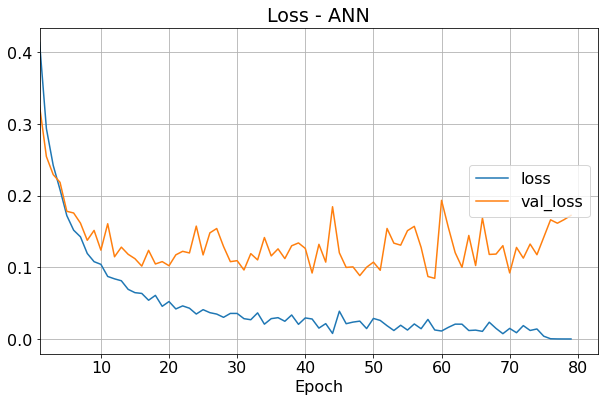

In [19]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10, 6))
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

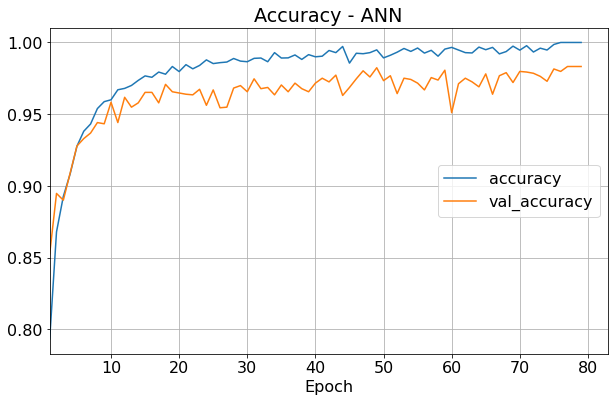

In [20]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [21]:
# Predict test set labels
y_pred_ann_proba = model_ann.predict(X_test, verbose=0)
y_pred_ann = np.where(y_pred_ann_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_ann):.5f}')

Accuracy: 0.97561


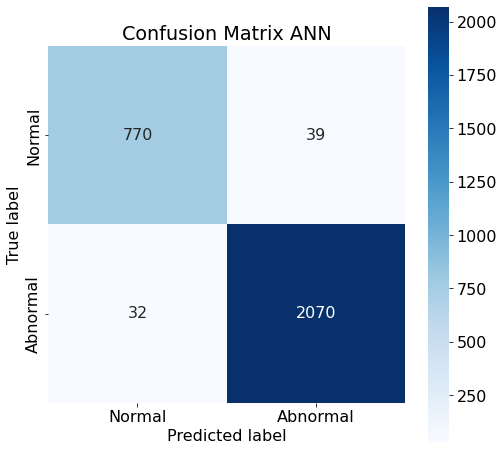

In [22]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix ANN')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [23]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.95179234 0.9847764 ]
Macro/average accuracy:  0.968284369821431


In [24]:
report = classification_report(y_test, y_pred_ann, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, "ANN", 2)

              precision    recall  f1-score   support

      Normal     0.9601    0.9518    0.9559       809
    Abnormal     0.9815    0.9848    0.9831      2102

    accuracy                         0.9756      2911
   macro avg     0.9708    0.9683    0.9695      2911
weighted avg     0.9756    0.9756    0.9756      2911



### False Positive Rate

In [25]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  32
Percentage of sick persons that are classified as normal:  1.5223596574690772 %


# CNN

In [27]:
im_shape=(X_train.shape[1],1)

model_cnn = Sequential([
    Convolution1D(64, (6), activation='relu', input_shape=im_shape),
    BatchNormalization(),
    MaxPool1D(pool_size=(3), strides=(2), padding="same"),
    Convolution1D(64, (3), activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=(2), strides=(2), padding="same"),
    Convolution1D(64, (3), activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=(2), strides=(2), padding="same"),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath='train_model.h5', monitor='val_loss', save_best_only=True)]

history_cnn = model_cnn.fit(X_train, y_train, epochs=100, callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))

model_cnn.load_weights('train_model.h5')
save_model(model_cnn, 'Simple_CNN_PTBDB', 'keras')


Epoch 1/100
291/291 [==============================] - 10s 27ms/step - loss: 0.2563 - accuracy: 0.8870 - val_loss: 1.0369 - val_accuracy: 0.7221
Epoch 2/100
291/291 [==============================] - 8s 29ms/step - loss: 0.1155 - accuracy: 0.9556 - val_loss: 0.8302 - val_accuracy: 0.7406
Epoch 3/100
291/291 [==============================] - 8s 27ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.3249 - val_accuracy: 0.8928
Epoch 4/100
291/291 [==============================] - 7s 25ms/step - loss: 0.0497 - accuracy: 0.9822 - val_loss: 0.0712 - val_accuracy: 0.9766
Epoch 5/100
291/291 [==============================] - 7s 24ms/step - loss: 0.0368 - accuracy: 0.9872 - val_loss: 0.0898 - val_accuracy: 0.9722
Epoch 6/100
291/291 [==============================] - 7s 24ms/step - loss: 0.0236 - accuracy: 0.9914 - val_loss: 0.1264 - val_accuracy: 0.9626
Epoch 7/100
291/291 [==============================] - 7s 26ms/step - loss: 0.0218 - accuracy: 0.9927 - val_loss: 0.3032 - val_accuracy

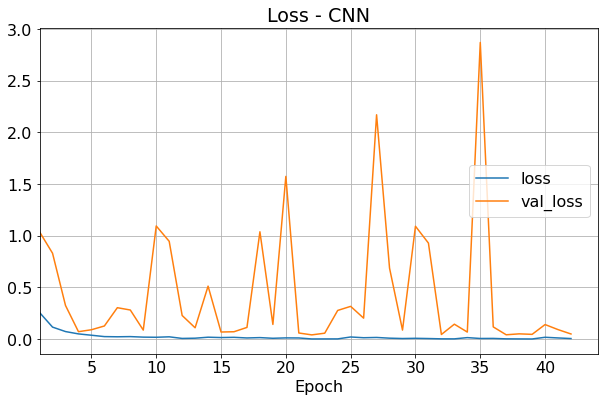

In [28]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10, 6))
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

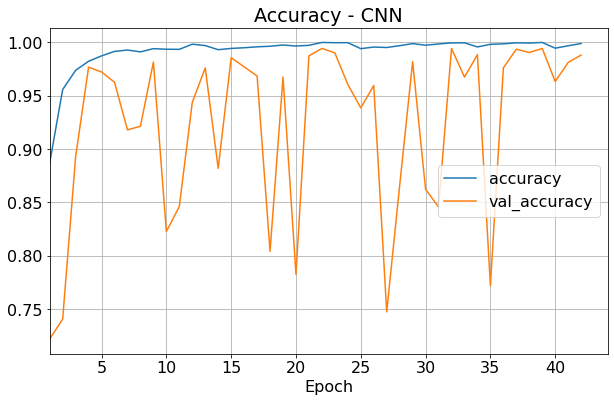

In [29]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [30]:
# Predict test set labels
y_pred_cnn_proba = model_cnn.predict(X_test, verbose=0)
y_pred_cnn = np.where(y_pred_cnn_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy:" {accuracy_score(y_test, y_pred_cnn):.5f}')

Accuracy:" 0.99416


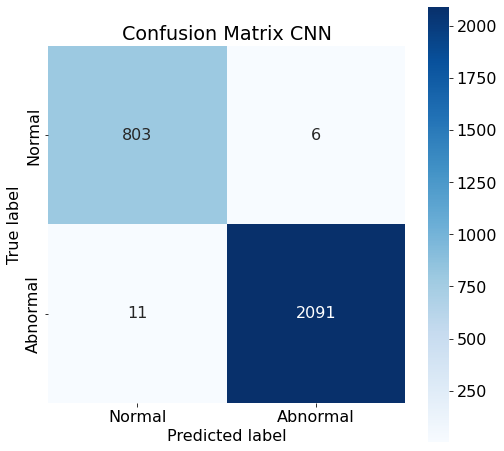

In [31]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix CNN')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [32]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.99258344 0.99476689]
Macro/average accuracy:  0.993675162509306


In [33]:
report = classification_report(y_test, y_pred_cnn, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, "CNN", 2)

              precision    recall  f1-score   support

      Normal     0.9865    0.9926    0.9895       809
    Abnormal     0.9971    0.9948    0.9960      2102

    accuracy                         0.9942      2911
   macro avg     0.9918    0.9937    0.9927      2911
weighted avg     0.9942    0.9942    0.9942      2911



### False Positive Rate

In [34]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  11
Percentage of sick persons that are classified as normal:  0.5233111322549953 %
